<a href="https://colab.research.google.com/github/Axis121/AMLS_assignment22_23/blob/main/B2_Eye_Colour_Manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## general imports
import cv2 # manipulating images
import dlib # for face detection
from google.colab.patches import cv2_imshow 
from natsort import natsorted 
import os # to navigate file directories
from os import listdir
import pickle # used to save models

## imports for feature extraction
from skimage.feature import greycomatrix, greycoprops # used to calculate texture features of image

## imports for manipulating and visualising data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2 # test to select most signifacnt features
from sklearn.preprocessing import StandardScaler 

## imports for model building
from sklearn.model_selection import GridSearchCV # cross validation/ grid search for hyper-parameter tuning
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier

## imports for model evaluation
from sklearn import metrics
import seaborn as sns # graphing confusion matrices
from sklearn.model_selection import learning_curve # plot learning curve for a model

##move all imports here


In [ ]:
def faceLandmarks(im):

    # Path for the detection model
    PREDICTOR_PATH = r"/content/drive/MyDrive/Colab Notebooks/Test_folder/shape_predictor_68_face_landmarks.dat"
    
    # Create object to detect the face
    faceDetector = dlib.get_frontal_face_detector()

    # Create object to detect the facial landmarks
    landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

    # Detect faces
    faceRects = faceDetector(im, 0)

    # Initialize landmarksAll array
    landmarksAll = []

    # For each face detected in the image, this chunk of code creates a ROI around the face and pass it as an argument to the 
    # facial landmark detector and append the result to the array landmarks 
    for i in range(0, len(faceRects)):
        newRect = dlib.rectangle(int(faceRects[i].left()),
                            int(faceRects[i].top()),
                            int(faceRects[i].right()),
                            int(faceRects[i].bottom()))
        landmarks = landmarkDetector(im, newRect)
        landmarksAll.append(landmarks)

    return landmarksAll, faceRects

In [ ]:
def renderFacialLandmarks(im, landmarks):
    
    # Convert landmarks into iteratable array
    points = []
    [points.append((p.x, p.y)) for p in landmarks.parts()]

    # Loop through array and draw a circle for each landmark
    for p in points:
        cv2.circle(im, (int(p[0]),int(p[1])), 2, (255,0,0),-1)

    # Return image with facial landmarks 
    return im

In [ ]:
def extractEyeFeatures(im_dir): 
  im = cv2.imread(im_dir)
  eye_img = cropEyes(im) # Load the cropped image of the eye

  # make empty feature array
  feature_array = np.zeros((1,15)) # column dimension hard coded to number of features used

  # Extract the red, green, and blue channels of the image
  red_channel = eye_img[:,:,2]
  green_channel = eye_img[:,:,1]
  blue_channel = eye_img[:,:,0]

  # Calculate mean, median and standard deviation of each channel
  feature_array[0,0] = np.mean(red_channel)
  feature_array[0,1] = np.mean(green_channel)
  feature_array[0,2] = np.mean(blue_channel)
  feature_array[0,3] = np.median(red_channel)
  feature_array[0,4] = np.median(green_channel)
  feature_array[0,5] = np.median(blue_channel)
  feature_array[0,6] = np.std(red_channel)
  feature_array[0,7] = np.std(green_channel)
  feature_array[0,8] = np.std(blue_channel)
  feature_array[0,9] = np.mean(eye_img) # feature of combined channels
  feature_array[0,10] = np.median(eye_img)
  feature_array[0,11] = np.std(eye_img)

  # Calculate the GLCM (grey-level co-occurence matrix) for the image
  grey_eye = cv2.cvtColor(eye_img, cv2.COLOR_BGR2GRAY) # convert eye image to black and white
  glcm = greycomatrix(grey_eye, [1], [0], levels=256, symmetric=True, normed=True)

  # Extract texture features from the GLCM
  feature_array[0,12] = greycoprops(glcm, 'contrast')
  feature_array[0,13] = greycoprops(glcm, 'correlation')
  feature_array[0,14] = greycoprops(glcm, 'homogeneity')

  return feature_array

In [ ]:
def extractFeatures(folder_dir): 
    number_of_features = 15
    features = np.ones((1,number_of_features))*10 #initialise the feature array, row dimension is unknown so rows will be appended eachh time
    current_features = np.zeros((1,number_of_features))

    for images in natsorted(os.listdir(folder_dir)):
    
        # check if the image ends with png
        if (images.endswith(".png")):
            
            print(images) # for testing
            ##use images to finish the directory call for im
            ## Read an image to a variable
            im = cv2.imread(folder_dir +"/" + images)
            landmarks, _ = faceLandmarks(im) # do initial scan of image

            if len(landmarks) == 0: #set image row to 0 if no face detected
              current_features [0,:]=0
            else:
              current_features = extractEyeFeatures(folder_dir +"/" + images)

        features = np.vstack((features,current_features)) # vertically combine the returned feature array of each image
    
    features = np.delete(features,0,axis = 0) # remove placeholder first row, does not represent an image
    return features
    print("done")
            

In [ ]:
def getLabel(label_dir,column):
  df = pd.read_csv(label_dir)

  ## replace "-1" labels with a "0", not used in multiclass problems
  df = df.replace(-1,0)
  labels = df.iloc[:,column].values # face shape is the 3rd coloumn, eye colour is the 2nd
  labels = np.transpose(labels)

  return labels

In [ ]:
def removeMissingValues (features, labels): # data rows corresponding to image that could not have a face detected
  row,cols = features.shape

  featuresAndLabels = np.column_stack((features,labels)) # combine the features and labels into one matrix, horizontally
  featuresAndLabels = featuresAndLabels[~np.all(featuresAndLabels[:,:136] == 0, axis=1)] #remove rows if the feature row section is full of zeroes
  clean_features = featuresAndLabels [:,:cols] # remake feature matrix
  clean_labels = featuresAndLabels [:,cols] # remake label vector

  return clean_features, clean_labels

In [ ]:
def cropEyes(img):
  PREDICTOR_PATH = r"/content/drive/MyDrive/Colab Notebooks/Test_folder/shape_predictor_68_face_landmarks.dat" ### make into variable

  # Create a facial landmark detector
  predictor = dlib.shape_predictor(PREDICTOR_PATH)

  # Detect faces in the image
  detector = dlib.get_frontal_face_detector()
  faces = detector(img)

  if len(faces) > 0:
    # Get the facial landmarks for the first face
    shape = predictor(img, faces[0])

    # Get the coordinates for the eyes
    left_eye_x = shape.part(36).x
    left_eye_y = shape.part(36).y
    right_eye_x = shape.part(39).x
    right_eye_y = shape.part(39).y

    # get the width of the rectangle
    eye_distance = right_eye_x - left_eye_x
    rect_width = eye_distance

    # get the height of the rectangle
    eye_to_chin_distance = abs(shape.part(38).y - shape.part(41).y)
    rect_height = eye_to_chin_distance

    # Crop the image to just the region containing one eye, eyes are assumed to be the same colour for a given person
    left_eye_img = img[left_eye_y-rect_height:left_eye_y+rect_height, left_eye_x:left_eye_x+rect_width]

    # Save the cropped images
    cv2.imwrite("left_eye.jpg", left_eye_img)

    return left_eye_img

In [ ]:
## initial extraction of features
folder_dir = "/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/cartoon_set/img" # training + validation iamges
features = extractFeatures(folder_dir)
np.save("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B2/cartoon_eyes_set.npy",features) # saving features to file

Loading saved features and importing labels

In [ ]:
features = np.load("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B2/cartoon_eyes_set.npy")

In [ ]:
## obtaining labels
label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/cartoon_set/labels_modified.csv' # training + validation labels
labels = getLabel(label_dir,column = 1) # get label vector

Dataset Pre-Processing Stage

In [ ]:
clean_features, clean_labels = removeMissingValues (features, labels)  # remove image rows with missing values

Visualisation of Data




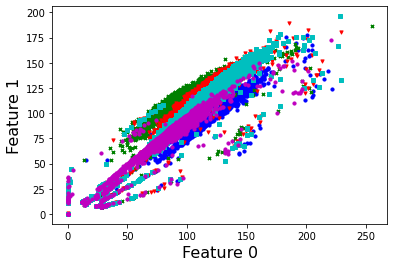

In [ ]:
## plot features against each other with points coloured based on label
## separate data into an array for each unique class

indices = np.where(clean_labels[:] == 0)
class_0 = clean_features [indices,:]

indices = np.where(clean_labels[:] == 1)
class_1 = clean_features [indices,:]

indices = np.where(clean_labels[:] == 2)
class_2 = clean_features [indices,:]

indices = np.where(clean_labels[:] == 3)
class_3 = clean_features [indices,:]

indices = np.where(clean_labels[:] == 4)
class_4 = clean_features [indices,:]

#
fig = plt.figure()
ax1 = fig.add_subplot(111)

## control which features are plotted against each other
## can vary variable value from 0 to 15 (inclusive) to obtain different plot
feature1 = 0 # feature of x axis
feature2 = 1 # feature of y axis

ax1.scatter(class_0[0,:,feature1], class_0[0,:,feature2], s=10, c='b', marker="o")
ax1.scatter(class_1[0,:,feature1], class_1[0,:,feature2], s=10, c='g', marker="x")
ax1.scatter(class_2[0,:,feature1], class_2[0,:,feature2], s=10, c='r', marker="v")
ax1.scatter(class_3[0,:,feature1], class_3[0,:,feature2], s=10, c='c', marker="s")
ax1.scatter(class_4[0,:,feature1], class_4[0,:,feature2], s=10, c='m', marker="o")

plt.xlabel("Feature "+ str(feature1),fontsize=16)
plt.ylabel("Feature "+ str(feature2),fontsize=16)
plt.show()

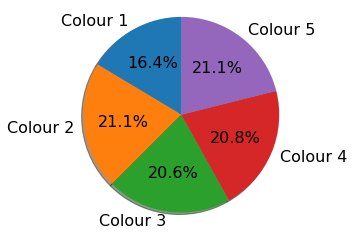

In [ ]:
## Pie Chart Visualisation
unique, counts = np.unique(clean_labels, return_counts=True) # get population numbers for each class

# Make pie chart
labels = 'Colour 1', 'Colour 2', 'Colour 3', 'Colour 4', 'Colour 5'
sizes = counts
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Splitting processed data into training and validation image sets.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validate, Y_train, Y_validate = train_test_split(clean_features, clean_labels, test_size=0.3,random_state=109) # 70% training and 30% test

Obtain test set from separate directory of images

In [ ]:
##make a check to see if load file exists then reload, if it does not exist then extract.??

In [ ]:
## Extract Features
folder_dir = "/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/cartoon_set_test/img" # test set
features = extractFeatures(folder_dir)
np.save("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B2/cartoon_eye_feature_test_set.npy",features) # saving features to a file

In [ ]:
## reload features from saved file and get labels
features_test = np.load("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B2/cartoon_eye_feature_test_set.npy")

## obtain labels
label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/cartoon_set_test/modified_labels.csv' # test set labels
labels_test = getLabel(label_dir,column = 1) # get label vector

In [ ]:
## Match naming conventions
X_test = features_test
Y_test = labels_test

Building Machine Learning Models: Training, Validation and Testing

In [ ]:
## scaling/normalising feature matrices of each set
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)  
X_test_s = scaler.transform(X_test)
X_validate_s = scaler.transform(X_validate)

Logistic Regression

In [ ]:
## Tuning hyper parameters of logistic regression model using validation set

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              "penalty":["l2"],
              "max_iter" : [100,200,500,1000]
			}

grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_validate_s, Y_validate)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'max_iter': 200, 'penalty': 'l2'}
LogisticRegression(C=10, max_iter=200)


In [ ]:
## Validation of tuned parameters using test set
grid_predictions = grid.predict(X_test_s)

# print classification report
print(metrics.classification_report(Y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82       398
         1.0       0.87      0.63      0.73       483
         2.0       0.83      0.65      0.73       525
         3.0       0.53      0.85      0.66       514
         4.0       0.69      0.67      0.68       472

    accuracy                           0.71      2392
   macro avg       0.76      0.71      0.72      2392
weighted avg       0.75      0.71      0.72      2392



In [ ]:
# train tuned logistic regression model with training set
logr_model = LogisticRegression(max_iter = 200, penalty = "l2", C = 10).fit(X_train_s, Y_train)
# evaluate performance using test set
preds = logr_model.predict(X_test_s)
print(metrics.classification_report(preds, Y_test))
print(metrics.confusion_matrix(Y_test,preds))

              precision    recall  f1-score   support

         0.0       0.62      0.80      0.70       389
         1.0       0.64      0.90      0.74       344
         2.0       0.87      0.49      0.63       926
         3.0       0.61      0.77      0.68       409
         4.0       0.65      0.71      0.68       432

    accuracy                           0.68      2500
   macro avg       0.68      0.74      0.69      2500
weighted avg       0.72      0.68      0.67      2500



array([[312,   4, 126,  31,  33],
       [ 12, 308, 107,  20,  36],
       [ 16,   9, 456,  19,  25],
       [ 24,  12, 132, 316,  30],
       [ 25,  11, 105,  23, 308]])

SVM (RBF)

In [ ]:
## Tuning hyper parameters of svm rbf model using validation set

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_validate_s, Y_validate)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.746 total time=   0.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.730 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.699 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.751 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.732 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.718 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.692 total time=   0.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.676 total time=   0.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.714 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.707 total time=   0.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.598 total time=   0.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=100, gamma=0.1)


In [ ]:
# evaluating performance of tune parameters
grid_predictions = grid.predict(X_test_s)

# print classification report
print(metrics.classification_report(Y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.91      0.81      0.86       398
         1.0       0.83      0.72      0.77       483
         2.0       0.90      0.68      0.77       525
         3.0       0.56      0.89      0.69       514
         4.0       0.85      0.74      0.79       472

    accuracy                           0.77      2392
   macro avg       0.81      0.77      0.78      2392
weighted avg       0.81      0.77      0.77      2392



In [ ]:
## training tuned model based on training set
## {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

#Create a svm Classifier
rbf_svm_model = svm.SVC(decision_function_shape='ovr',kernel='rbf', C = 100, gamma = 0.1) #

#Train the model using the training sets
rbf_svm_model.fit(X_train_s, Y_train)

In [ ]:
# Evaluate performance of model using test set
y_pred = rbf_svm_model.predict(X_test_s)

print(metrics.classification_report(y_pred, Y_test))
print(metrics.confusion_matrix(Y_test,y_pred))
cm_svm = metrics.confusion_matrix(Y_test,y_pred) # stored to be used to graph confusion matrix for report

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       395
         1.0       0.68      0.97      0.80       341
         2.0       0.90      0.57      0.70       838
         3.0       0.68      0.79      0.73       443
         4.0       0.70      0.89      0.78       375

    accuracy                           0.76      2392
   macro avg       0.76      0.81      0.77      2392
weighted avg       0.79      0.76      0.76      2392

[[334   1  25  26  12]
 [ 17 330  96  23  17]
 [ 17   4 475  24   5]
 [ 15   6 136 348   9]
 [ 12   0 106  22 332]]


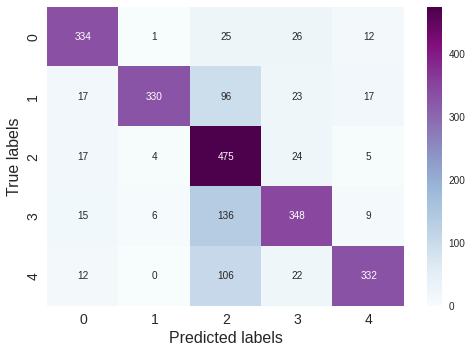

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm_svm, annot=True, fmt='g', ax=ax, cmap="BuPu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 16);ax.set_ylabel('True labels', fontsize = 16); 
#ax.set_title('Confusion Matrix of the Logistic Classifier'); 
font_size = 14 
ax.tick_params(labelsize = font_size)
ax.xaxis.set_ticklabels(['0', '1', "2", "3", "4"]); ax.yaxis.set_ticklabels(['0', '1', "2", "3", "4"]); # x axis = 0, 1 | y axis = 0,1

#######change max iter, and other params

Multi-Layer Perceptron (MLP)

In [ ]:
# Define the parameter grid to search over
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
              'learning_rate': ['constant', 'invscaling', 'adaptive'],
              "hidden_layer_sizes" : [12],
              "solver" : ['adam']}

# Create an instance of the MLPClassifier
mlp = MLPClassifier()

# Create an instance of the GridSearchCV object
grid_search = GridSearchCV(mlp, param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(X_validate_s, Y_validate)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

Best parameters:  {'alpha': 0.1, 'hidden_layer_sizes': 12, 'learning_rate': 'adaptive'}
Best score:  0.740418118466899


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# print best parameters after tuning
print(grid_search.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid_search.best_estimator_)

{'alpha': 0.1, 'hidden_layer_sizes': 12, 'learning_rate': 'adaptive'}
MLPClassifier(alpha=0.1, hidden_layer_sizes=12, learning_rate='adaptive')


In [ ]:
## evaluating performance of model using the test set
grid_predictions = grid_search.predict(X_test_s)

# print classification report
print(metrics.classification_report(Y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85       398
         1.0       0.47      0.84      0.61       483
         2.0       0.95      0.62      0.75       525
         3.0       0.70      0.67      0.68       514
         4.0       0.90      0.68      0.78       472

    accuracy                           0.72      2392
   macro avg       0.79      0.72      0.73      2392
weighted avg       0.79      0.72      0.73      2392



In [ ]:
# create MLP using tuned parameters

clf = MLPClassifier(solver='adam', alpha=0.1,
                    hidden_layer_sizes=(12), 
                    random_state=1, 
                    learning_rate = 'adaptive')
clf = clf.fit(X_train_s, Y_train)
y_pred_mlp = clf.predict(X_test_s)

print(metrics.classification_report(y_pred_mlp, Y_test))
print(metrics.confusion_matrix(Y_test,y_pred_mlp))

              precision    recall  f1-score   support

         0.0       0.66      0.77      0.71       436
         1.0       0.67      0.91      0.77       352
         2.0       0.88      0.52      0.65       897
         3.0       0.65      0.79      0.71       419
         4.0       0.70      0.83      0.76       396

    accuracy                           0.71      2500
   macro avg       0.71      0.77      0.72      2500
weighted avg       0.75      0.71      0.71      2500

[[336   7 117  27  19]
 [ 21 322  96  28  16]
 [ 22   6 464  20  13]
 [ 27  11 125 333  18]
 [ 30   6  95  11 330]]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Save the model to be reloaded later

In [ ]:
# save the model to disk
filename = 'B2_colour_model.sav'
pickle.dump(rbf_svm_model, open(filename, 'wb'))

In [ ]:
# load the model from disk
filename = 'B2_colour_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
## Test loaded model
result = loaded_model.score(X_test, Y_test)
print(result)

Examination of Learning Curve

In [ ]:
#rebuild untrained model that achieved highest performance
estimator = svm.SVC(decision_function_shape='ovr',kernel='rbf', C = 100, gamma = 0.1) 
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train_s, Y_train, cv = 5, return_times=True)

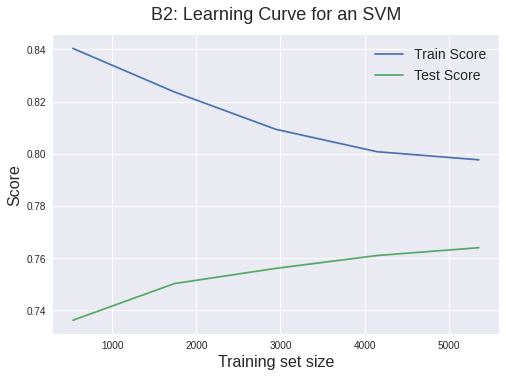

In [ ]:
## plotting learning curve
plt.style.use('seaborn')
plt.plot(train_sizes,np.mean(train_scores,axis=1))
plt.plot(train_sizes,np.mean(test_scores,axis=1))
plt.ylabel('Score', fontsize = 16)
plt.xlabel('Training set size', fontsize = 16)
plt.title('B2: Learning Curve for an SVM', fontsize = 18, y = 1.03)
plt.legend(["Train Score", "Test Score"],prop={'size': 14})
plt.show()